### Sentiment Classification Using XLM-RoBERTa

By: Fawad Kirmani

Last modified on: 11/08/2020

In [16]:
import glob
import os
import pandas as pd
import numpy as np
from numpy import array
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Importing data

In [2]:
pos_train_file = "./aclImdb_v1/aclImdb/train/pos/"
neg_train_file = "./aclImdb_v1/aclImdb/train/neg/"
pos_test_file = "./aclImdb_v1/aclImdb/test/pos/"
neg_test_file = "./aclImdb_v1/aclImdb/test/neg/"

In [3]:
input_files = [pos_train_file, neg_train_file, pos_test_file, neg_test_file]

In [4]:
def import_data(filename):
    file_list = glob.glob(os.path.join(os.getcwd(), filename, "*.txt"))

    input_data = []

    for file_path in file_list:
        with open(file_path) as f_input:
            input_data.append(f_input.read())
    return input_data

In [5]:
def overall_data(input_files):
    data = pd.DataFrame()
    for i in range(len(input_files)):
        df = pd.DataFrame(import_data(filename=input_files[i]), columns = ["reviews"])
        if input_files[i].find("/pos") > 0:
            df["label"] = 1
        else:
            df["label"] = 0
        if input_files[i].find("/train") > 0:
            df["data_type"] = "train"
        else:
            df["data_type"] = "test"
        data = data.append(df)
    data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data.dropna(axis=0,inplace=True)
    return data

In [6]:
data = overall_data(input_files=input_files)

In [7]:
data.head()

,reviews,label,data_type
0,This is one of the best films we watched in my...,1,train
1,Spoiler This movie is about such a concept. Wi...,1,train
2,Richard Attenborough is a director whose name ...,1,train
3,"Joan Crawford had just begun her ""working girl...",1,train
4,I have just read the lead comment for this fil...,1,train


Used the following tutorials to learn training language models using ktrain

https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed

#### Importing Ktrain

In [8]:
import ktrain
from ktrain import text

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data["reviews"], data['label'], test_size=0.10, random_state=80)

In [10]:
X_train = array(X_train)
X_test = array(X_test)
y_train = array(y_train)
y_test = array(y_test)

#### Processing input data with XLM-RoBERTa model and max length of 256

In [18]:
t = text.Transformer("xlm-mlm-en-2048", maxlen=256, classes=[0,1])

/home/fkirmani/anaconda3/envs/astro/lib/python3.6/site-packages/ktrain/text/preprocessor.py:380: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


In [19]:
train = t.preprocess_train(X_train, y_train)

preprocessing train...
language: en
train sequence lengths:
	mean : 231
	95percentile : 591
	99percentile : 910


Is Multi-Label? False


In [20]:
test = t.preprocess_test(X_test, y_test)

preprocessing test...
language: en
test sequence lengths:
	mean : 231
	95percentile : 585
	99percentile : 878


In [21]:
model = t.get_classifier()
xlm_learner = ktrain.get_learner(model, train_data=train, val_data=test, batch_size=32)

#### finding a good learning rate

In [16]:
xlm_learner.lr_find(max_epochs=1)

simulating training for different learning rates... this may take a few moments...
1406/1406 [==============================] - 38091s 27s/step - loss: 66.5359 - accuracy: 0.5126


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


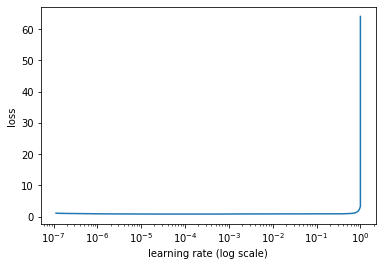

In [17]:
xlm_learner.lr_plot()

#### Training model with 3 epochs

In [18]:
xlm_learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1407/1407 [==============================] - 15961s 11s/step - loss: 0.3126 - accuracy: 0.8613 - val_loss: 0.2155 - val_accuracy: 0.9156
Epoch 2/3
1407/1407 [==============================] - 15935s 11s/step - loss: 0.1992 - accuracy: 0.9239 - val_loss: 0.2167 - val_accuracy: 0.9178
Epoch 3/3
1407/1407 [==============================] - 15804s 11s/step - loss: 0.1224 - accuracy: 0.9561 - val_loss: 0.2215 - val_accuracy: 0.9232


It seems like a case of overfitting with training for 3 epochs

#### Classification Report of the model with maxlen = 256

In [19]:
xlm_learner.validate(val_data=test, class_names=[0,1])

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2551
           1       0.91      0.93      0.92      2449

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



array([[2327,  224],
       [ 160, 2289]])

#### #### Processing input data with XLM-RoBERTa model and max length of 512

In [11]:
t = text.Transformer("xlm-roberta-base", maxlen=512, classes=[0,1])

/home/fkirmani/anaconda3/envs/astro/lib/python3.6/site-packages/ktrain/text/preprocessor.py:380: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


In [12]:
train = t.preprocess_train(X_train, y_train)

preprocessing train...
language: en
train sequence lengths:
	mean : 231
	95percentile : 591
	99percentile : 910


Is Multi-Label? False


In [13]:
test = t.preprocess_test(X_test, y_test)

preprocessing test...
language: en
test sequence lengths:
	mean : 231
	95percentile : 585
	99percentile : 878


In [14]:
model = t.get_classifier()
xlm_learner = ktrain.get_learner(model, train_data=train, val_data=test, batch_size=32)

### finding a good learning rate with 2 epochs

In [ ]:
xlm_learner.lr_find(max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
   8/1406 [..............................] - ETA: 9:46:15 - loss: 0.7047 - accuracy: 0.4219

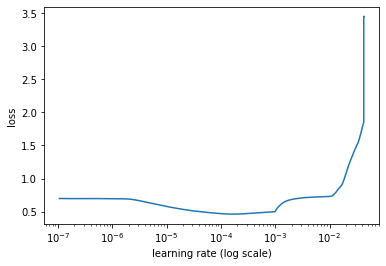

In [17]:
xlm_learner.lr_plot()

Training model with two epochs

In [ ]:
xlm_learner.fit_onecycle(2e-5, 2)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
 702/1407 [=============>................] - ETA: 5:26:30 - loss: 0.3545 - accuracy: 0.8361

#### Classification Report of the model with maxlen = 512

In [21]:
xlm_learner.validate(val_data=test, class_names=[0,1])

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2551
           1       0.94      0.94      0.94      2449

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



array([[2415,  136],
       [ 150, 2299]])

#### Confusion Matrix

In [22]:
cm = array([[2425,  136], [150, 2299]])

In [23]:
cm

array([[2425,  136],
       [ 150, 2299]])

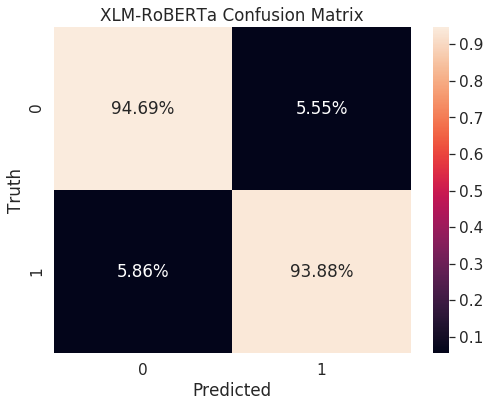

In [28]:
cm_df = pd.DataFrame(cm, range(2), range(2)) 
plt.figure(figsize = (8, 6)) 
plt.title('XLM-RoBERTa' + ' Confusion Matrix')
sn.set(font_scale=1.4) #for label size 
sn.heatmap(cm_df/np.sum(cm_df, axis=1), annot=True, fmt='.2%')
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.savefig('./figures/' + 'XLM' + '_confusion_matrix_normalized.png', dpi=300)
plt.show()